In [1]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [37]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import GridSearchCV

In [3]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

### 각 feature가 무엇을 의미하는가?

Data fields

- ID : 집을 구분하는 번호
- date : 집을 구매한 날짜
- price : 집의 가격(Target variable)
- bedrooms : 침실의 수
- bathrooms : 화장실의 수
- sqft_living : 주거 공간의 평방 피트(면적)
- sqft_lot : 부지의 평방 피트(면적)
- floors : 집의 층 수
- waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
- view : 집이 얼마나 좋아 보이는지의 정도
- condition : 집의 전반적인 상태
- grade : King County grading 시스템 기준으로 매긴 집의 등급
- sqft_above : 지하실을 제외한 평방 피트(면적)
- sqft_basement : 지하실의 평방 피트(면적)
- yr_built : 지어진 년도
- yr_renovated : 집을 재건축한 년도
- zipcode : 우편번호
- lat : 위도
- long : 경도
- sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
- sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)


In [4]:
train

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,610685.0,4,2.50,2520,6023,2.0,0,0,...,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,1007500.0,4,3.50,3510,7200,2.0,0,0,...,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


In [5]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [6]:
print(len(train.columns), len(test.columns))

21 20


In [7]:
y = train['price']
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [8]:
del train['price']

In [9]:
data = pd.concat((train, test), axis = 0, ignore_index = 1)
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,21498,20140626T000000,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,21499,20150126T000000,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,21500,20150219T000000,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21501,21501,20140623T000000,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


<AxesSubplot:>

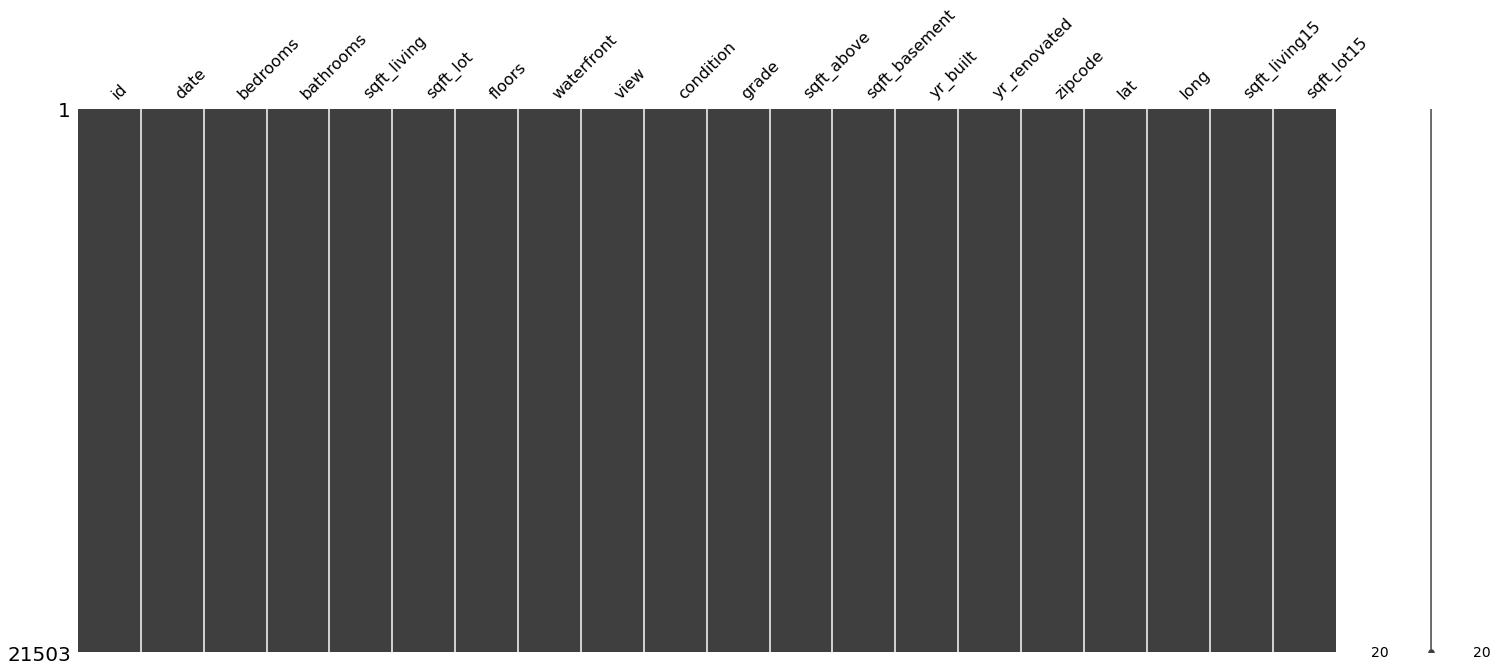

In [10]:
# 결측치 검색
msno.matrix(data)

In [11]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


In [12]:
del data['id']

In [13]:
data['date'] = data['date'].apply(lambda x : str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 데이터 보면서 든 생각
1. rooms = bedrooms + bathrooms
2. date가 2014면 sqft_living, sqft_lot 적용    
2015면 sqft_living15, sqft_lot15 적용
3. 다른 feature들과 연관이 깊은 feature를 제거 (다중공선성?)

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_l

In [15]:
# 1. rooms = bedrooms + bathrooms
data['rooms'] = data['bedrooms'] + data['bathrooms']

In [16]:
del data['bedrooms']
del data['bathrooms']

data

,date,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms
0,201410,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00
1,201502,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00
2,201502,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00
3,201406,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25
4,201501,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,4.75
21499,201501,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,5.00
21500,201502,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,5.50
21501,201406,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2.75


In [17]:
data['sqft_living_apply_date'] = 0
data['sqft_lot_apply_date'] = 0
data

,date,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,sqft_living_apply_date,sqft_lot_apply_date
0,201410,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0,0
1,201502,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0,0
2,201502,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0,0
3,201406,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0,0
4,201501,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,4.75,0,0
21499,201501,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,5.00,0,0
21500,201502,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,5.50,0,0
21501,201406,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2.75,0,0


In [18]:
# 2. 2014 vs. 2015
for i in range(len(data)):
    if data['date'][i][:4] == '2014':
        data['sqft_living_apply_date'][i] = data['sqft_living'][i]
    elif data['date'][i][:4] == '2015':
        data['sqft_living_apply_date'][i] = data['sqft_living15'][i]
    else:
        data['sqft_living_apply_date'][i] = data['sqft_living'][i]

for i in range(len(data)):
    if data['date'][i][:4] == '2014':
        data['sqft_lot_apply_date'][i] = data['sqft_lot'][i]
    elif data['date'][i][:4] == '2015':
        data['sqft_lot_apply_date'][i] = data['sqft_lot15'][i]
    else:
        data['sqft_lot_apply_date'][i] = data['sqft_lot'][i]
        
data

,date,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,sqft_living_apply_date,sqft_lot_apply_date
0,201410,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,1180,5650
1,201502,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,2720,8062
2,201502,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,1800,7503
3,201406,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,1715,6819
4,201501,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,4.75,1500,11968
21499,201501,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,5.00,1400,1230
21500,201502,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,5.50,1330,1265
21501,201406,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2.75,1020,1350


In [19]:
del data['sqft_living']
del data['sqft_living15']
del data['sqft_lot']
del data['sqft_lot15']

data

,date,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,rooms,sqft_living_apply_date,sqft_lot_apply_date
0,201410,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,4.00,1180,5650
1,201502,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,3.00,2720,8062
2,201502,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,5.00,1800,7503
3,201406,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,5.25,1715,6819
4,201501,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,4.50,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,4.75,1500,11968
21499,201501,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,5.00,1400,1230
21500,201502,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,5.50,1330,1265
21501,201406,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,2.75,1020,1350


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21503 entries, 0 to 21502
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    21503 non-null  object 
 1   floors                  21503 non-null  float64
 2   waterfront              21503 non-null  int64  
 3   view                    21503 non-null  int64  
 4   condition               21503 non-null  int64  
 5   grade                   21503 non-null  int64  
 6   sqft_above              21503 non-null  int64  
 7   sqft_basement           21503 non-null  int64  
 8   yr_built                21503 non-null  int64  
 9   yr_renovated            21503 non-null  int64  
 10  zipcode                 21503 non-null  int64  
 11  lat                     21503 non-null  float64
 12  long                    21503 non-null  float64
 13  rooms                   21503 non-null  float64
 14  sqft_living_apply_date  21503 non-null

In [21]:
len(train)

15035

In [22]:
temp_train = data[:15035]
temp_train

,date,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,rooms,sqft_living_apply_date,sqft_lot_apply_date
0,201410,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,4.00,1180,5650
1,201502,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,3.00,2720,8062
2,201502,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,5.00,1800,7503
3,201406,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,5.25,1715,6819
4,201501,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,4.50,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,201410,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,6.50,2520,6023
15031,201503,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,7.50,2050,6200
15032,201405,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,5.50,1530,1131
15033,201502,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,6.50,1830,7200


In [23]:
# Pearson correlation과 Spearman rank correlation을 활용해서 어떠한 feature가 집값 상승에 영향을 미치는지 파악하기
# Pearson : -1은 음이 상관관계, 0은 상관관계 없음, 1은 양의 상관관계

for feature in temp_train.columns:
    try:
        print("Pearson correlation btw price and {} : ".format(feature), np.corrcoef(y, temp_train[feature])[0][1])
    except: # date의 경우 수치데이터가 아니어서 직접적인 비교가 불가함.
        continue

Pearson correlation btw price and floors :  0.26258786775720033
Pearson correlation btw price and waterfront :  0.26573831930479
Pearson correlation btw price and view :  0.40080590947836675
Pearson correlation btw price and condition :  0.03973979621020223
Pearson correlation btw price and grade :  0.6672107746564202
Pearson correlation btw price and sqft_above :  0.6085774049666446
Pearson correlation btw price and sqft_basement :  0.32221832963676933
Pearson correlation btw price and yr_built :  0.0472903255115606
Pearson correlation btw price and yr_renovated :  0.14080798220500146
Pearson correlation btw price and zipcode :  -0.05149842561440092
Pearson correlation btw price and lat :  0.3016038939886894
Pearson correlation btw price and long :  0.023546513995481338
Pearson correlation btw price and rooms :  0.4755260861526092
Pearson correlation btw price and sqft_living_apply_date :  0.6755096873386017
Pearson correlation btw price and sqft_lot_apply_date :  0.09102905627868296


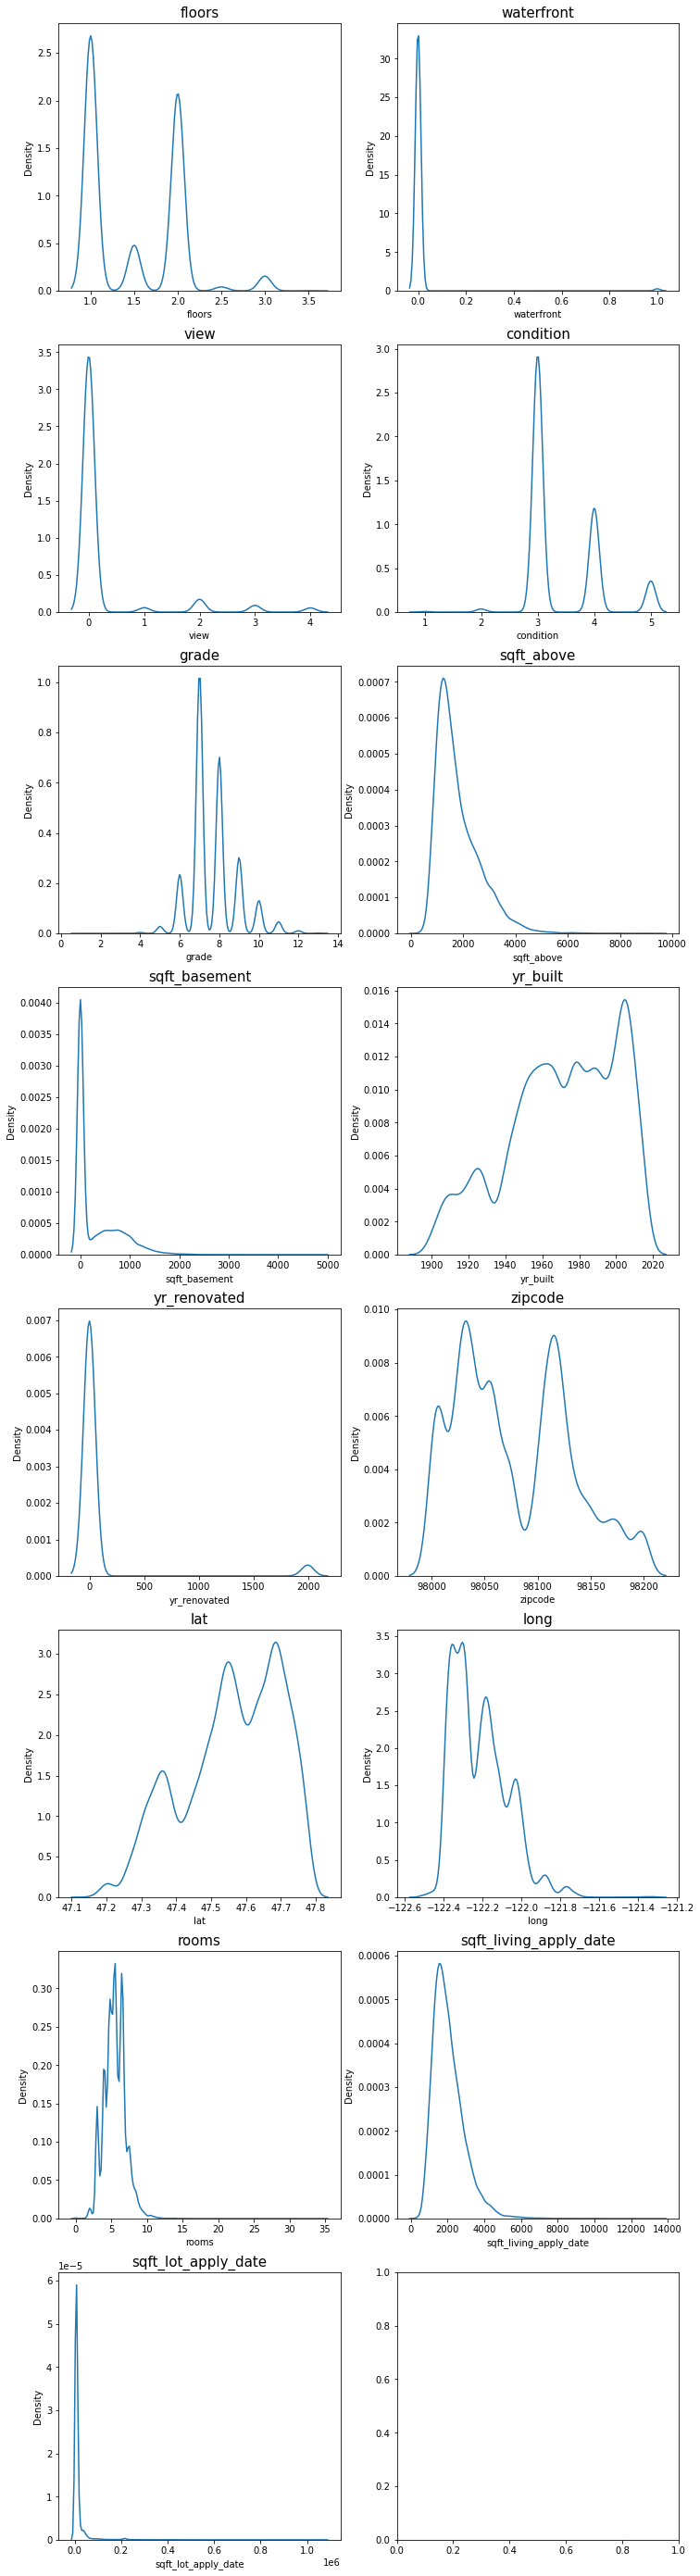

In [27]:
# 정규화
fig, ax = plt.subplots(8, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(8):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 16:
            break

In [29]:
skew_columns = ['sqft_above', 'sqft_basement', 'sqft_living_apply_date', 'sqft_lot_apply_date']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)

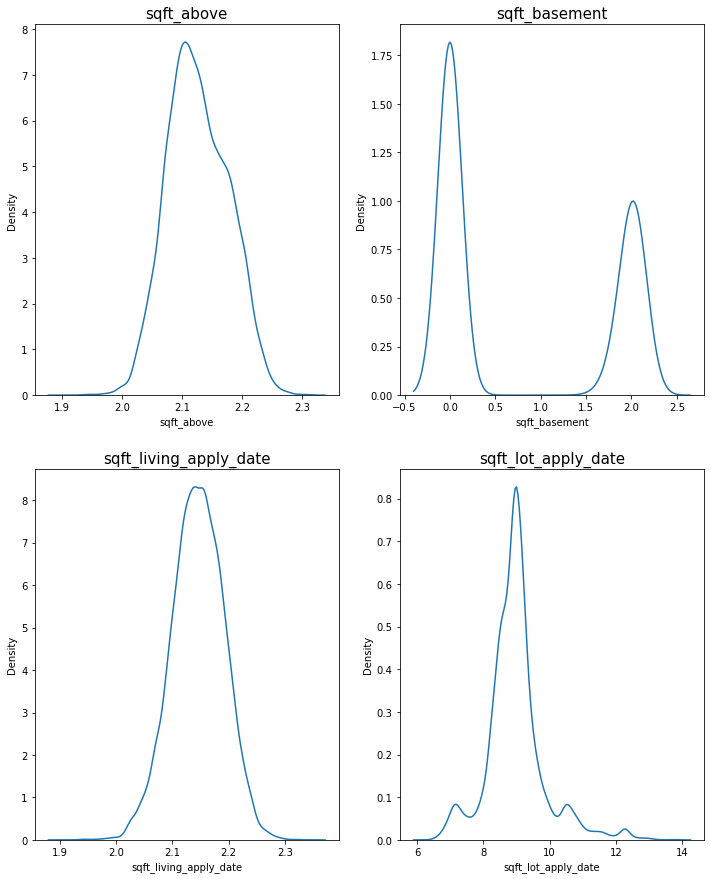

In [32]:
fig, ax = plt.subplots(2, 2, figsize=(12, 15))

count = 0
for row in range(2):
    for col in range(2):
        if count == 4:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

In [34]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [43]:
del data['date']

In [44]:
train_data = data[:len(train)]
test_data = data[len(train):]

In [45]:
train_data

,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,rooms,sqft_living_apply_date,sqft_lot_apply_date
0,1.0,0,0,3,7,2.088663,0.000000,1955,0,98178,47.5112,-122.257,4.00,2.088663,8.639588
1,1.0,0,0,3,6,2.034403,0.000000,1933,0,98028,47.7379,-122.233,3.00,2.187034,8.995041
2,1.0,0,0,3,8,2.131458,0.000000,1987,0,98074,47.6168,-122.045,5.00,2.139607,8.923191
3,2.0,0,0,3,7,2.133900,0.000000,1995,0,98003,47.3097,-122.327,5.25,2.133900,8.827615
4,1.0,0,0,3,7,2.075304,0.000000,1963,0,98198,47.4095,-122.315,4.50,2.129319,9.181118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,2.0,0,0,3,9,2.178428,0.000000,2014,0,98056,47.5137,-122.167,6.50,2.178428,8.703507
15031,2.0,0,0,3,9,2.181959,2.055986,2009,0,98136,47.5537,-122.398,7.50,2.154790,8.732466
15032,3.0,0,0,3,8,2.120305,0.000000,2009,0,98103,47.6993,-122.346,5.50,2.120305,7.031741
15033,2.0,0,0,3,8,2.168532,0.000000,2014,0,98146,47.5107,-122.362,6.50,2.141549,8.881975


In [46]:
test_data

,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,rooms,sqft_living_apply_date,sqft_lot_apply_date
15035,2.0,0,0,3,7,2.161361,1.945047,1951,1991,98125,47.7210,-122.319,5.25,2.180649,8.887791
15036,1.0,0,0,5,7,2.074115,2.055986,1965,0,98136,47.5208,-122.393,7.00,2.149575,8.517393
15037,1.0,0,0,3,11,2.226397,2.120305,2001,0,98053,47.6561,-122.005,8.50,2.261558,11.532051
15038,1.0,0,0,3,7,2.074115,2.027413,1960,0,98146,47.5123,-122.337,4.00,2.138292,9.001346
15039,2.0,0,0,3,7,2.145330,0.000000,2003,0,98038,47.3684,-122.031,5.50,2.172416,8.932080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,1.0,0,0,3,6,2.117927,0.000000,2014,0,98010,47.3095,-122.002,4.75,2.117927,9.390075
21499,3.0,0,0,3,8,2.117123,0.000000,2014,0,98144,47.5699,-122.288,5.00,2.109600,7.115582
21500,2.0,0,0,3,8,2.088663,1.770740,2008,0,98116,47.5773,-122.409,5.50,2.103364,7.143618
21501,2.0,0,0,3,7,2.070469,0.000000,2009,0,98144,47.5944,-122.299,2.75,2.070469,7.208600


In [35]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [38]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [39]:
# 각 모델의 이름은 클래스의 __name__ 속성에 접근해서 얻을 수 있다.
gboost.__class__.__name__

'GradientBoostingRegressor'

In [48]:
def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

get_scores(models, train_data, y)

,RMSE
GradientBoostingRegressor,132736.889104
RandomForestRegressor,128411.215069
LGBMRegressor,113881.092242
XGBRegressor,111122.919522


In [49]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 10, 20, 30],
}

In [58]:
model = LGBMRegressor(random_state=random_state)

In [59]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train_data, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:    2.2s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_depth': [1, 10, 20, 30],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error', verbose=1)

In [60]:
grid_model.cv_results_

{'mean_fit_time': array([0.03965406, 0.05407376, 0.08099408, 0.09751029, 0.1648057 ,
        0.26296844, 0.09819622, 0.16726952, 0.2778749 , 0.10008221,
        0.16039257, 0.26169076]),
 'std_fit_time': array([0.0030962 , 0.00168259, 0.00539752, 0.00352893, 0.00331055,
        0.01319175, 0.00507024, 0.0039556 , 0.01563187, 0.00655525,
        0.0078046 , 0.01464221]),
 'mean_score_time': array([0.00420132, 0.00629892, 0.00952897, 0.00789213, 0.01499867,
        0.02635207, 0.00813117, 0.01497197, 0.02703285, 0.00803752,
        0.01506343, 0.02548771]),
 'std_score_time': array([0.0003343 , 0.00070337, 0.00103075, 0.00032399, 0.00025154,
        0.00191582, 0.00057878, 0.00063074, 0.00248025, 0.00034899,
        0.00158634, 0.00325753]),
 'param_max_depth': masked_array(data=[1, 1, 1, 10, 10, 10, 20, 20, 20, 30, 30, 30],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dty

In [61]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.077145
1,1,100,-0.058572
2,1,200,-0.048191
3,10,50,-0.030980
4,10,100,-0.028605
5,10,200,-0.027784
6,20,50,-0.030859
7,20,100,-0.028463
8,20,200,-0.027645
9,30,50,-0.030859


In [62]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})

results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.077145,0.277751
1,1,100,-0.058572,0.242017
2,1,200,-0.048191,0.219526
3,10,50,-0.030980,0.176010
4,10,100,-0.028605,0.169129
5,10,200,-0.027784,0.166687
6,20,50,-0.030859,0.175666
7,20,100,-0.028463,0.168709
8,20,200,-0.027645,0.166269
9,30,50,-0.030859,0.175666


In [63]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
8,20,200,-0.027645,0.166269
11,30,200,-0.027645,0.166269
5,10,200,-0.027784,0.166687
7,20,100,-0.028463,0.168709
10,30,100,-0.028463,0.168709
4,10,100,-0.028605,0.169129
6,20,50,-0.030859,0.175666
9,30,50,-0.030859,0.175666
3,10,50,-0.030980,0.176010
2,1,200,-0.048191,0.219526


In [64]:
model = LGBMRegressor(max_depth=20, n_estimators=200, random_state=random_state)
model.fit(train_data, y)
prediction = model.predict(test_data)
prediction

array([13.13051454, 13.10095347, 14.17798611, ..., 13.04161155,
       12.67601881, 12.97313377])

In [65]:
prediction = np.expm1(prediction)
prediction

array([ 504091.23700339,  489407.83046887, 1436881.08867349, ...,
        461210.2907863 ,  319980.61208226,  430684.65639493])

In [67]:
# submission 파일 생성

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [68]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.040912e+05
1,15036,4.894078e+05
2,15037,1.436881e+06
3,15038,2.888115e+05
4,15039,3.379812e+05


In [73]:
# csv 파일로 생성
submission.to_csv('./final_submission_usingLGBM.csv', index=False)

In [74]:
# XGBRegressor로 진행
model = XGBRegressor(random_state=random_state)

In [75]:
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(train_data, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:  1.0min
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:  1.8min finished


KeyError: 'base_score'

KeyError: 'base_score'

In [76]:
params = grid_model.cv_results_['params']
score = grid_model.cv_results_['mean_test_score']

results = pd.DataFrame(params)
results['score'] = score

results

,max_depth,n_estimators,score
0,1,50,-0.052023
1,1,100,-0.045964
2,1,200,-0.041790
3,10,50,-0.031657
4,10,100,-0.032020
5,10,200,-0.032200
6,20,50,-0.034207
7,20,100,-0.034202
8,20,200,-0.034202
9,30,50,-0.034726


In [77]:
results['RMSE'] = np.sqrt(-1 * results['score'])
results = results.rename(columns={'RMSE': 'RMSLE'})

results

,max_depth,n_estimators,score,RMSLE
0,1,50,-0.052023,0.228086
1,1,100,-0.045964,0.214393
2,1,200,-0.041790,0.204425
3,10,50,-0.031657,0.177925
4,10,100,-0.032020,0.178941
5,10,200,-0.032200,0.179444
6,20,50,-0.034207,0.184953
7,20,100,-0.034202,0.184938
8,20,200,-0.034202,0.184938
9,30,50,-0.034726,0.186349


In [78]:
results = results.sort_values('RMSLE')
results

,max_depth,n_estimators,score,RMSLE
3,10,50,-0.031657,0.177925
4,10,100,-0.032020,0.178941
5,10,200,-0.032200,0.179444
7,20,100,-0.034202,0.184938
8,20,200,-0.034202,0.184938
6,20,50,-0.034207,0.184953
9,30,50,-0.034726,0.186349
10,30,100,-0.034726,0.186349
11,30,200,-0.034726,0.186349
2,1,200,-0.041790,0.204425


In [79]:
model = XGBRegressor(max_depth=10, n_estimators=50, random_state=random_state)
model.fit(train_data, y)
prediction = model.predict(test_data)
prediction

array([13.0432415, 12.982625 , 14.088314 , ..., 13.123652 , 12.724462 ,
       13.0425005], dtype=float32)

In [80]:
prediction = np.expm1(prediction)
prediction

array([ 461962.66,  434791.88, 1313641.1 , ...,  500643.97,  335863.  ,
        461620.47], dtype=float32)

In [81]:
# submission 파일 생성

data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [82]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.619627e+05
1,15036,4.347919e+05
2,15037,1.313641e+06
3,15038,2.640464e+05
4,15039,3.383116e+05


In [83]:
# csv 파일로 생성
submission.to_csv('./final_submission_usingXGB.csv', index=False)

### final score

- 최종 스코어는 115036이 나왔다.

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FMyb0B%2FbtqW4gM9J0d%2FIdUKiWPKM5z9eKjsOTEoiK%2Fimg.png" width="1000px" height="400px"></img>

# 회고
## * 이번 프로젝트에서 어려웠던 점.
아무래도 처음 하는 캐글 대회이다 보니 진행방식이나 좋은 score를 받기 위해 어떤 부분들이 필요한지에 대해 미흡한 점이 많았던 것 같습니다. 다행히 노드를 진행하면서 큰 틀에서 진행과정을 익히고 최종 파일 제출까지 진행해볼 수 있어서 좋았습니다. 하지만, 여전히 좋은 score를 받기 위해서는 어떠한 작업들이 추가로 이루어져야 하는지에 대해서는 어려운 것 같습니다. (이 부분에 대해서는 다른 사람들의 공유된 파일을 참고하면서 채워나가야 할 것 같습니다.)


## * 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
프로젝트를 진행하다보니 자연스럽게 score를 낮추기 위한 노력들을 하게 되었습니다. 진행 중 다중공선성이라는 개념도 마주하게 되었는데, 프로젝트를 제출하는 지금까지도 이 부분에 대해서는 개념이 확 와닿지가 않습니다. 여러 개의 feature들 중에서 하나의 feature가 다른 feature들과 서로 연관이 높은 경우 학습 시 해당 feature를 제거해주고 학습하는 것이 모델 성능에 도움이 된다..가 제가 이해한 부분인데, 이러한 feature를 어떻게 찾아낼 수 있는지는 잘 모르겠습니다.

LGBM 모델이 가벼우면서도 성능이 좋다는 것을 알게되었습니다. 4개 정도의 모델을 실험해보았을 때, 신기하게도 LightGradientBoost의 성능이 가장 좋았습니다.


## * 루브릭 평가 지표를 맞추기 위해 시도한 것들.
1) 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전 과정이 성공적으로 진행되었는가?
    Yes. 전체 과정을 거쳐서 submission까지 성공하였습니다.
    
2) 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
    Yes. 전처리, 학습, 최적화 과정 모두 순서대로 진행하려 노력하였습니다.
    
3) 다양한 피쳐 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?
    No. 피쳐 엔지니어링, 하이퍼 파라미터 튜닝 등 최적화 기법은 사용하였으나 캐글 리더보드의 점수는 115036점으로 11만점 이하의 점수는 얻지 못했습니다.